In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [12]:
import os
import pandas as pd

# Path to the directory containing the image files
#change the path
directory = 'C://Users/gauth/OneDrive/Desktop/DIP PROJECT/g3'

# List to store extracted information
data = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    # Split filename by ".chip" to get the main part
    main_part = filename.split(".chip")[0]
    
    # Split main part by "_" to extract age and gender
    age, gender, *rest = main_part.split("_")
    
    # Convert gender to string representation
    gender = "Male" if gender == "0" else "Female"
    
    # Join the rest of the filename back together (if any)
    rest = "_".join(rest)
    
    # Append extracted information to the list
    data.append({'Filename': filename, 'Age': int(age), 'Gender': gender})

# Create DataFrame from the extracted information
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                              Filename  Age  Gender
0    10_0_0_20170110225505288.jpg.chip - Copy - Cop...   10    Male
1    10_0_0_20170110225601897.jpg.chip - Copy - Cop...   10    Male
2    10_0_0_20170116201337172.jpg.chip - Copy - Cop...   10    Male
3    10_0_0_20170117135444407.jpg.chip - Copy - Cop...   10    Male
4               116_1_2_20170112220255503.jpg.chip.jpg  116  Female
..                                                 ...  ...     ...
145  7_0_0_20170110215620675.jpg.chip - Copy - Copy...    7    Male
146  7_0_0_20170110215633251.jpg.chip - Copy - Copy...    7    Male
147              85_1_0_20170110182128680.jpg.chip.jpg   85  Female
148              96_1_2_20170110182504813.jpg.chip.jpg   96  Female
149              96_1_2_20170110182526540.jpg.chip.jpg   96  Female

[150 rows x 3 columns]


In [13]:
import numpy as np
import cv2
import os
import os
from ultralytics import YOLO


#loading caffe models
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']




#path for images
folder_path = 'C://Users/gauth/OneDrive/Desktop/DIP PROJECT/g3'

# List all image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) ]
#No of images
print(len(image_files))


# Iterate over each image
result_list=[]
#yolo model being used for face detection
model=YOLO("yolov8n-face.pt")
for image_file in image_files:
    # Read image
    img = cv2.imread(image_file)
    #getting results yolo model
    results=model(img)
    result_list.append(results)
    boxes=results[0].boxes
    
    
    #looping over the faces detected from yolo
    for box in boxes:
        top_left_x=int(box.xyxy.tolist()[0][0])
        top_left_y=int(box.xyxy.tolist()[0][1])
        bottom_right_x=int(box.xyxy.tolist()[0][2])
        bottom_right_y=int(box.xyxy.tolist()[0][3])
        
        cv2.rectangle(img,( top_left_x,top_left_y),(bottom_right_x,  bottom_right_y),(255,0,0),2)
        detected_face=img[top_left_y:bottom_right_y,  top_left_x:bottom_right_x]
        
        #procedure for clahe equalization
        lab_img= cv2.cvtColor(detected_face, cv2.COLOR_BGR2LAB)

        #Splitting the LAB image to L, A and B channels, respectively
        l, a, b = cv2.split(lab_img)

      
        ########### basic Histogram Equlization#############
        #Apply histogram equalization to the L channel
        equ = cv2.equalizeHist(l)

      
        #Combine the Hist. equalized L-channel back with A and B channels
        updated_lab_img1 = cv2.merge((equ,a,b))

        #Convert LAB image back to color (RGB)
        hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)

        ###########CLAHE#########################
        #Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        
        #Combine the CLAHE enhanced L-channel back with A and B channels
        updated_lab_img2 = cv2.merge((clahe_img,a,b))

        #Convert LAB image back to color (RGB)
        CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)
        
        #Normal histogram 
        #cv2.imshow('Basic equlization',hist_eq_img)
        
        #cv2.imshow('CLAHE equlization', CLAHE_img)
        
        #blob input to caffe
        detected_face_blob = cv2.dnn.blobFromImage(CLAHE_img, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
      
        
        genderNet.setInput(detected_face_blob)
        ageNet.setInput(detected_face_blob)
        
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        
        
        agePreds=ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        
        print("gender",gender,"age",age)
        
        
        label = "{}{}".format(gender,age)
       
        cv2.putText(img, label, (top_left_x+20, top_left_y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
      
        #loading predicted results to the existing df
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Gender'] = gender
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Age'] = age
    #cv2.imshow("ok",img)
  
    cv2.waitKey(0)
    

       

cv2.destroyAllWindows()    
        
        
        




150

0: 480x640 1 face, 294.5ms
Speed: 32.5ms preprocess, 294.5ms inference, 16.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)

0: 480x640 1 face, 204.1ms
Speed: 0.0ms preprocess, 204.1ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (4-6)

0: 480x640 1 face, 165.4ms
Speed: 2.8ms preprocess, 165.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (38-43)

0: 480x640 1 face, 178.6ms
Speed: 2.6ms preprocess, 178.6ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)

0: 480x640 2 faces, 174.0ms
Speed: 8.5ms preprocess, 174.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)
gender Female age (60-100)
gender Female age (60-100)

0: 480x640 2 faces, 158.9ms
Speed: 0.0ms preprocess, 158.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (60-100)
gender Male age (60-100)

0: 480x640 1 face, 147.3ms
Speed: 8.0

gender Male age (38-43)

0: 480x640 1 face, 335.2ms
Speed: 7.5ms preprocess, 335.2ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (38-43)

0: 480x640 2 faces, 172.7ms
Speed: 5.7ms preprocess, 172.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (38-43)
gender Male age (25-32)

0: 480x640 2 faces, 159.5ms
Speed: 7.0ms preprocess, 159.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (38-43)
gender Male age (25-32)

0: 480x640 1 face, 181.0ms
Speed: 0.0ms preprocess, 181.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)

0: 480x640 1 face, 174.0ms
Speed: 0.0ms preprocess, 174.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)

0: 480x640 2 faces, 193.5ms
Speed: 0.0ms preprocess, 193.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)
gender Male age (48-53)



gender Male age (25-32)

0: 480x640 2 faces, 271.9ms
Speed: 8.0ms preprocess, 271.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (48-53)
gender Male age (25-32)

0: 480x640 1 face, 222.5ms
Speed: 0.0ms preprocess, 222.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (48-53)

0: 480x640 1 face, 231.9ms
Speed: 8.4ms preprocess, 231.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Female age (48-53)

0: 480x640 1 face, 202.9ms
Speed: 8.0ms preprocess, 202.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (48-53)

0: 480x640 1 face, 241.9ms
Speed: 5.8ms preprocess, 241.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Female age (25-32)

0: 480x640 1 face, 229.1ms
Speed: 0.0ms preprocess, 229.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
gender Male age (25-32)

0: 480x640 1 face, 250.1ms
Speed: 10.7ms prepr

In [14]:
df

,Filename,Age,Gender,Predicted_Gender,Predicted_Age
0,10_0_0_20170110225505288.jpg.chip - Copy - Cop...,10,Male,Male,(25-32)
1,10_0_0_20170110225601897.jpg.chip - Copy - Cop...,10,Male,Male,(4-6)
2,10_0_0_20170116201337172.jpg.chip - Copy - Cop...,10,Male,Male,(38-43)
3,10_0_0_20170117135444407.jpg.chip - Copy - Cop...,10,Male,Male,(25-32)
4,116_1_2_20170112220255503.jpg.chip.jpg,116,Female,Female,(60-100)
...,...,...,...,...,...
145,7_0_0_20170110215620675.jpg.chip - Copy - Copy...,7,Male,Male,(25-32)
146,7_0_0_20170110215633251.jpg.chip - Copy - Copy...,7,Male,Male,(25-32)
147,85_1_0_20170110182128680.jpg.chip.jpg,85,Female,Male,(48-53)
148,96_1_2_20170110182504813.jpg.chip.jpg,96,Female,Male,(25-32)


In [15]:
df[40:60]

,Filename,Age,Gender,Predicted_Gender,Predicted_Age
40,29_0_0_20170117010705850.jpg.chip.jpg,29,Male,Male,(25-32)
41,29_0_0_20170117122015236.jpg.chip.jpg,29,Male,Male,(25-32)
42,29_0_0_20170117122016549.jpg.chip.jpg,29,Male,Male,(25-32)
43,29_0_0_20170117122025363.jpg.chip.jpg,29,Male,Male,(25-32)
44,29_0_0_20170117130617573.jpg.chip.jpg,29,Male,Female,(48-53)
45,29_0_0_20170117171827563.jpg.chip.jpg,29,Male,Male,(25-32)
46,29_0_0_20170117180851443.jpg.chip.jpg,29,Male,Male,(25-32)
47,29_0_0_20170117202647791.jpg.chip.jpg,29,Male,Male,(38-43)
48,29_0_0_20170117202649479.jpg.chip.jpg,29,Male,Male,(25-32)
49,29_0_0_20170119195119659.jpg.chip.jpg,29,Male,Male,(25-32)


In [16]:
# Calculate accuracy for predicted age
correct_age_predictions = 0
for index, row in df.iterrows():
    actual_age = row['Age']
    predicted_age_range = row['Predicted_Age']
    if isinstance(predicted_age_range, str):  # Check if the predicted age range is a string
        predicted_age_start, predicted_age_end = map(int, predicted_age_range.strip('()').split('-'))  # Extract start and end of predicted age range
        if actual_age >= predicted_age_start and actual_age <= predicted_age_end:
            correct_age_predictions += 1

total_images = df.shape[0]
age_accuracy = correct_age_predictions / total_images * 100



# Calculate accuracy for predicted gender
correct_gender_predictions = (df['Gender'] == df['Predicted_Gender']).sum()
gender_accuracy = correct_gender_predictions / total_images * 100

# Print results
print("Accuracy for predicted age: {:.2f}%".format(age_accuracy))
print("Accuracy for predicted gender: {:.2f}%".format(gender_accuracy))

Accuracy for predicted age: 30.67%
Accuracy for predicted gender: 70.00%


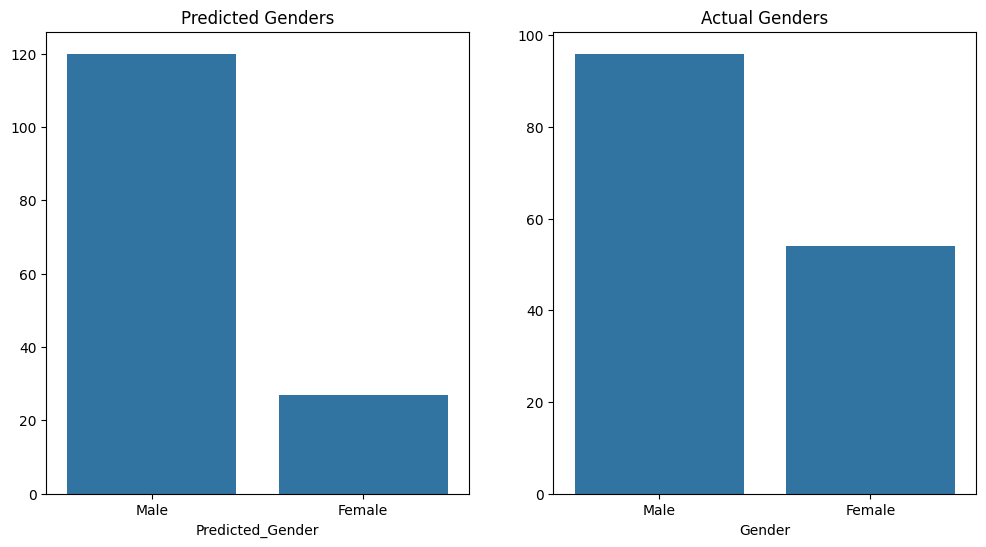

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted genders
sns.barplot(x=predicted_gender_counts.index, y=predicted_gender_counts.values, ax=axes[0])
axes[0].set_title('Predicted Genders')

# Plot actual genders
sns.barplot(x=actual_gender_counts.index, y=actual_gender_counts.values, ax=axes[1])
axes[1].set_title('Actual Genders')

# Adjust layout to prevent overlap


# Show the plot
plt.show()


C:\Users\gauth\AppData\Local\Temp\ipykernel_20740\4158931325.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
C:\Users\gauth\AppData\Local\Temp\ipykernel_20740\4158931325.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")


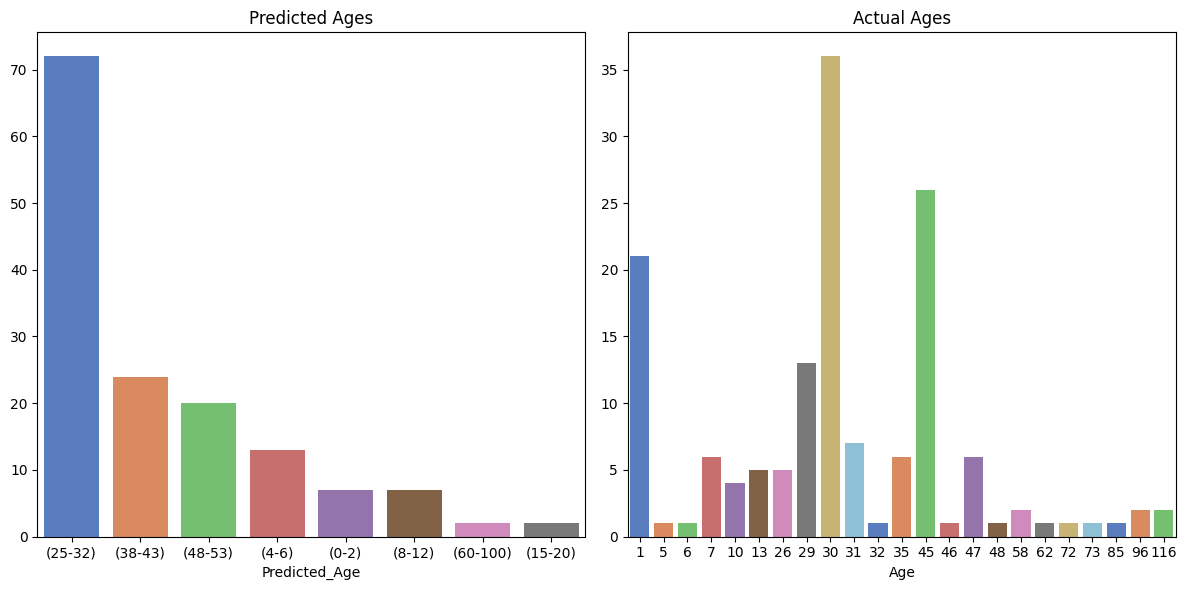

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of predicted and actual ages
predicted_age_counts = df['Predicted_Age'].value_counts()
actual_age_counts = df['Age'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted ages
sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
axes[0].set_title('Predicted Ages')

# Plot actual ages
sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")
axes[1].set_title('Actual Ages')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


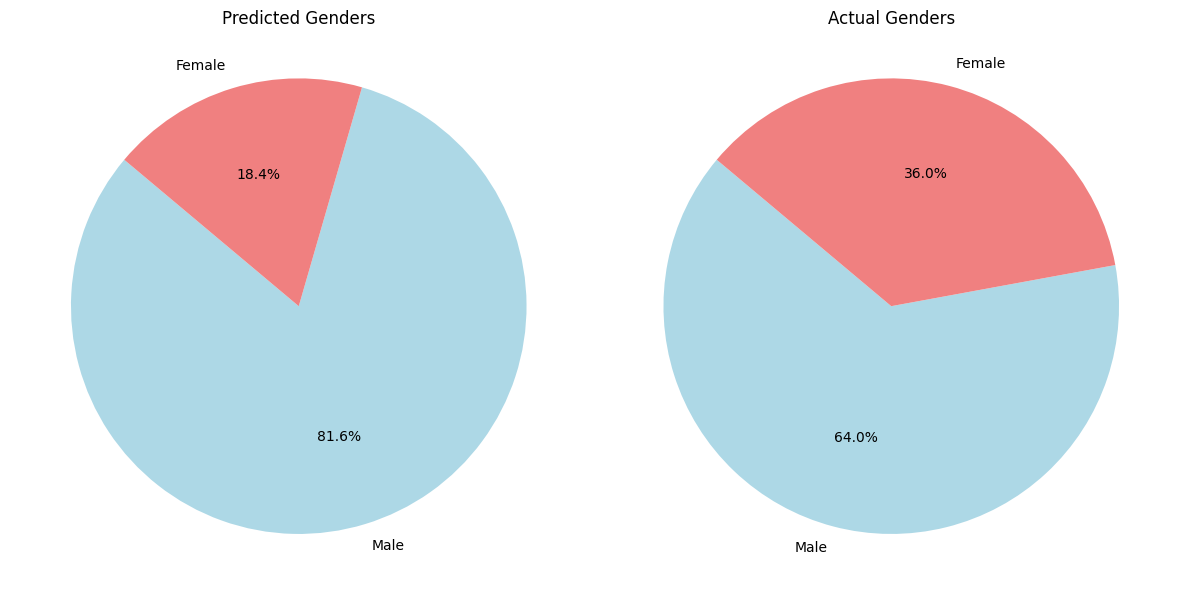

In [19]:


# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a pie chart for predicted genders
axes[0].pie(predicted_gender_counts, labels=predicted_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Predicted Genders')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Create a pie chart for actual genders
axes[1].pie(actual_gender_counts, labels=actual_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Actual Genders')
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


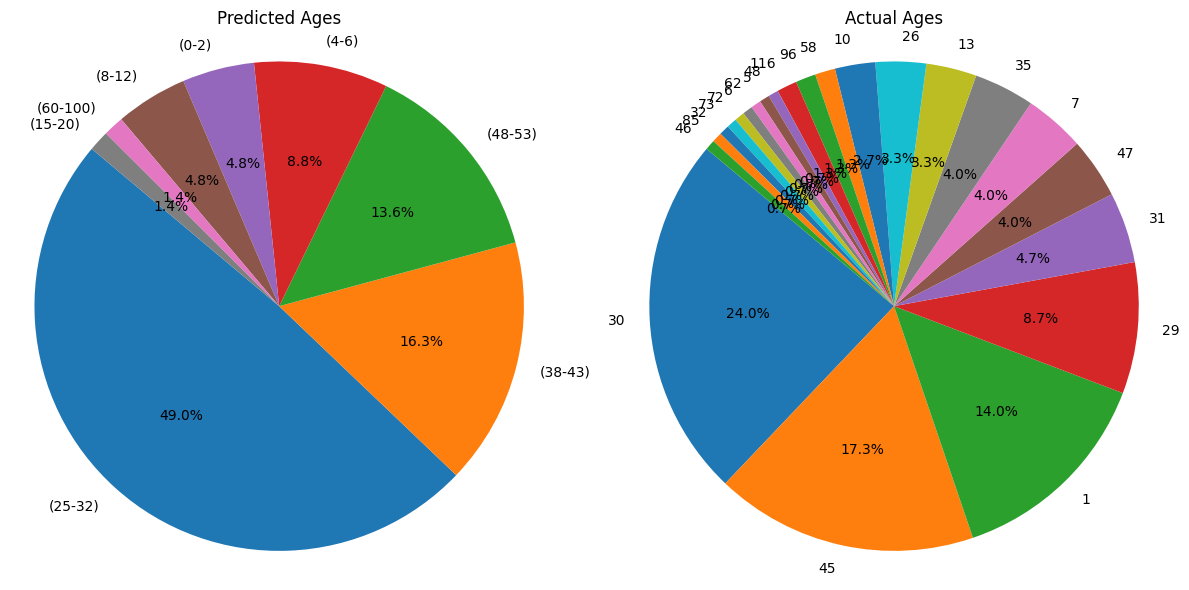

In [20]:
import matplotlib.pyplot as plt



# Create separate figures for ages
plt.figure(figsize=(12, 6))

# Plot pie chart for predicted ages
plt.subplot(1, 2, 1)
plt.pie(predicted_age_counts, labels=predicted_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Predicted Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plot pie chart for actual ages
plt.subplot(1, 2, 2)
plt.pie(actual_age_counts, labels=actual_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Actual Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots for ages
plt.show()


In [21]:
df['Predicted_Gender'].value_counts()

Predicted_Gender
Male      120
Female     27
Name: count, dtype: int64

In [22]:
df['Gender'].value_counts()

Gender
Male      96
Female    54
Name: count, dtype: int64